In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)

Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 320
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

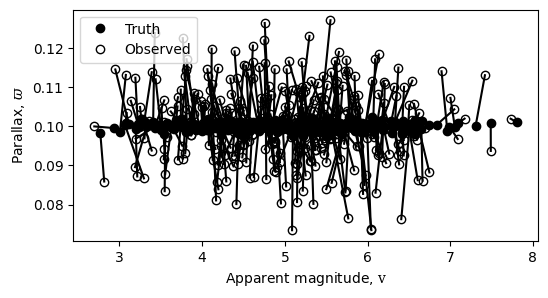

In [3]:
with plt.rc_context({"mathtext.fontset": "dejavuserif"}):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(mag, par, "ok", label="Truth")
    ax.plot(mag_obs, par_obs, "ok", markerfacecolor="none", label="Observed")
    ax.plot(np.stack([mag, mag_obs]), np.stack([par, par_obs]), "k")
#     ax.errorbar(2.1, 0.085, xerr=sigma_mag, yerr=sigma_par, color="k", capsize=4)

    ax.set_xlabel(r"Apparent magnitude, $\mathrm{v}$")
    ax.set_ylabel(r"Parallax, $\varpi$")
    ax.legend(loc="upper left")

In [4]:
def hierarchical_model(num_obs, par_obs=None, mag_obs=None):
    shape = (num_obs,)
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [5]:
dims = {
    "_d": ["Star"],
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}

In [6]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [7]:
data = {}
for n in [20, 80, 320]:
    coords = {"Star": np.arange(n)}
    rng, key = random.split(rng)
    mcmc.run(key, n, par_obs=par_obs[:n], mag_obs=mag_obs[:n])
    data[n] = az.from_numpyro(mcmc, coords=coords, dims=dims)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
nstars = r"$N_\mathrm{stars}$"
df = pd.concat(
    {k: v.posterior.to_dataframe() for k, v in data.items()},
    names=[nstars]
).reset_index()
df.head()

,$N_\mathrm{stars}$,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
0,20,0,0,0,1.691094,-0.610926,9.882733,4.363459,9.741076,0.101187,0.083767
1,20,0,0,1,0.332494,0.395485,9.768929,5.344719,9.741076,0.102365,0.083767
2,20,0,0,2,-1.403791,-0.270802,9.623486,4.645859,9.741076,0.103912,0.083767
3,20,0,0,3,-1.135609,1.116535,9.645950,6.038260,9.741076,0.103670,0.083767
4,20,0,0,4,2.417182,0.015989,9.943556,5.003697,9.741076,0.100568,0.083767


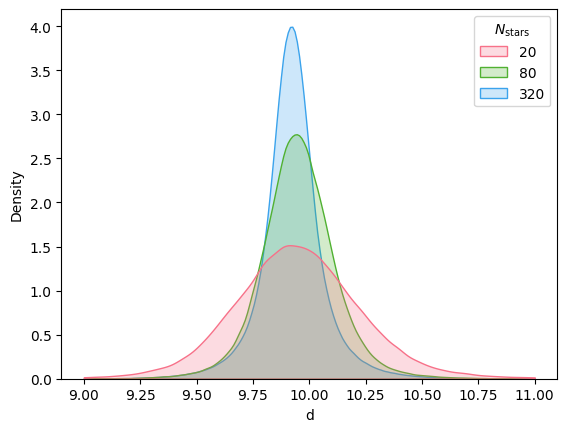

In [17]:
df.groupby(nstars).mean()

,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
$N_\mathrm{stars}$,,,,,,,,,,
20,4.5,499.5,9.5,0.002299,-0.049880,9.946907,4.937560,9.946550,0.100626,0.152545
80,4.5,499.5,39.5,-0.000327,-0.034650,9.949733,4.954071,9.949749,0.100536,0.107391
320,4.5,499.5,159.5,-0.000473,0.032569,9.922937,5.015528,9.922979,0.100799,0.109400


In [18]:
df.groupby(nstars).std()

,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
$N_\mathrm{stars}$,,,,,,,,,,
20,2.872289,288.675712,5.766296,1.001932,0.797755,0.302279,0.794725,0.226750,0.003055,0.150660
80,2.872283,288.675171,23.092221,0.996641,0.881183,0.175345,0.880388,0.109880,0.001770,0.089807
320,2.872282,288.675035,92.375606,0.999578,0.968199,0.148182,0.967965,0.055097,0.001507,0.084585


In [58]:
for k, v in data.items():
    print(
        k, 
        v.posterior.d.std(dim=("chain", "draw")).median().values, 
        v.posterior.abs_mag.std(dim=("chain", "draw")).median().values
    )

20 0.2954417 0.119086124
80 0.17360955 0.10691775
320 0.14620095 0.10497768


In [48]:
for i, group in df.groupby(nstars):
    print(group.quantile([.16, .5, .84]))

      $N_\mathrm{stars}$  chain    draw  Star        _d   abs_mag          d  \
0.16                20.0    1.0  159.84   3.0 -0.994838 -0.729906   9.675838   
0.50                20.0    4.5  499.50   9.5  0.002793 -0.187100   9.940767   
0.84                20.0    8.0  839.16  16.0  0.999168  0.997007  10.215135   

           mag       mu_d       par   sigma_d  
0.16  4.274285   9.717410  0.097894  0.037665  
0.50  4.803027   9.942258  0.100596  0.102355  
0.84  5.990708  10.170720  0.103350  0.265840  
      $N_\mathrm{stars}$  chain    draw  Star        _d   abs_mag          d  \
0.16                80.0    1.0  159.84  12.0 -0.993321 -0.874658   9.800198   
0.50                80.0    4.5  499.50  39.5  0.000872 -0.081457   9.946661   
0.84                80.0    8.0  839.16  67.0  0.990400  0.910115  10.098495   

           mag       mu_d       par   sigma_d  
0.16  4.114822   9.840385  0.099025  0.032478  
0.50  4.906828   9.950174  0.100536  0.079937  
0.84  5.898113  10.059

In [51]:
stat_funcs = {
    "median": np.median, 
    "lower": lambda x: np.median(x) - np.quantile(x, 0.16), 
    "upper": lambda x: np.quantile(x, 0.84) - np.median(x)
}

az.summary(data[20], var_names=["mu_d", "sigma_d"], stat_funcs=stat_funcs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,lower,upper
mu_d,9.947,0.227,9.508,10.356,0.004,0.003,3911.0,5529.0,1.0,9.942,0.225,0.228
sigma_d,0.153,0.151,0.003,0.439,0.003,0.002,2911.0,2307.0,1.0,0.102,0.065,0.163


In [52]:
az.summary(data[80], var_names=["mu_d", "sigma_d"], stat_funcs=stat_funcs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,lower,upper
mu_d,9.950,0.11,9.747,10.157,0.002,0.002,2352.0,4486.0,1.00,9.95,0.110,0.109
sigma_d,0.107,0.09,0.003,0.275,0.003,0.002,1813.0,1554.0,1.01,0.08,0.047,0.105


In [53]:
az.summary(data[320], var_names=["mu_d", "sigma_d"], stat_funcs=stat_funcs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,lower,upper
mu_d,9.923,0.055,9.818,10.024,0.001,0.001,3422.0,6059.0,1.00,9.923,0.055,0.054
sigma_d,0.109,0.085,0.006,0.268,0.004,0.003,506.0,745.0,1.02,0.085,0.052,0.108


In [43]:
sns.color_palette("husl", 3)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

See how the std for mu_d goes down by 1/2 then 1/2 again by the others don't quite. Likely due to limitations of observables.

In [41]:
import matplotlib as mpl
mpl.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"
mpl.rcParams["font.size"] = 12

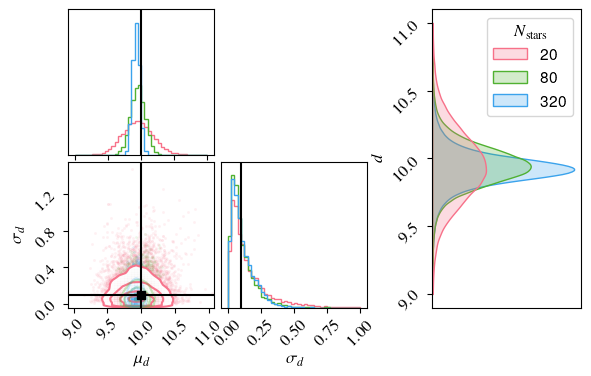

In [42]:
with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig = plt.figure(figsize=(6, 4))
    subfigs = fig.subfigures(1, 2, width_ratios=[2, 1])

    palette = sns.color_palette("husl", 3)
    rlim = [(9, 11), (0, 1)]
    labels = [r"$\mu_d$", r"$\sigma_d$"]

    for i, (k, v) in enumerate(data.items()):
        subfigs[0] = corner(
            v, 
            var_names=["mu_d", "sigma_d"], 
            truths={"mu_d": mu_d, "sigma_d": sigma_d} if i == 2 else None,
            truth_color="k",
            # color=f"C{i}",
            color=palette[i],
            range=rlim,
            smooth=1,
            bins=40,
            labels=labels,
            fig=subfigs[0],
        )

    ax = subfigs[1].subplots()
    ax = sns.kdeplot(df, y="d", hue=nstars, common_norm=False, fill=True,
                    palette=palette, clip=rlim[0], ax=ax)
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.tick_params(axis='y', labelrotation=45)
    ax.set_ylabel(r"$d$")

    fig.savefig("../figures/hbm-extended.pdf", dpi=300, format="pdf")